# Measuring rotation period from the lightcurve

Once we have used `tess_asteroids` to create a lightcurve, we might want to measure the rotation period of the asteroid. This tutorial will demonstrate a simple method to do this. 

We'll use the same example main-belt asteroid that we looked at in tutorial 1. In the JPL Small Body Database, 1980 VR1 is reported to have a rotation period of 10.215 hrs. Let's see if our lightcurve agrees with that.

In [1]:
from tess_asteroids import MovingTPF
import numpy as np
from astropy.timeseries import LombScargle
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

## Create the lightcurve

In [2]:
# Initialise MovingTPF for asteroid 1980 VR1 in TESS sector 1, camera 1, CCD 1
target = MovingTPF.from_name("1980 VR1", sector=1, camera=1, ccd=1)

# Make TPF
target.make_tpf()

# Make LC
target.make_lc()
lc = target.lc["aperture"]

Warning from TESSSpacecraft(): {message : ErfaWarning('ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"'), category : 'ErfaWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/erfa/core.py', lineno : 133, line : None}
Warning from prf.evaluate(): {message : LKPRFWarning('`targets` contains collateral pixels: Column(s) >= 2093 '), category : 'LKPRFWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/lkprf/tessprf.py', lineno : 56, line : None}
The PRF model contained nans in the first frame (cadence number 274). The model was replaced with that from the following frame (cadence number 275).
Warning from prf.evaluate(): {message : LKPRFWarning('`targets` contains collateral pixels: Column(s) >= 2093 '), category : 'LKPRFWarning', filename : '/Users/atuson/miniforge3/lib/python3.10/site-packages/lkprf/tessprf.py', lineno : 56, line : None}
The PRF model contained nans in the first frame (cadence number 274). The model was replaced wi

## Clean the data

In [3]:
# Remove nans from LC (the periodogram doesn't like nans!)

no_nan = np.logical_and(~np.isnan(np.array(lc["flux"])), ~np.isnan(np.array(lc["flux_err"])))
time, flux, flux_err = lc["time"][no_nan], lc["flux"][no_nan], lc["flux_err"][no_nan]
print("Before masking = {0}".format(len(lc["time"])))
print("After nan masking = {0}".format(len(time)))

Before masking = 972
After nan masking = 972


In [4]:
# Remove poor quality data from LC

# Define array of bad binary digits from SPOC (as recommended in the TESS archive manual, excluding those not included in FFI data)
bad_spoc_bits = [1,3,5,6,15]
spoc_value = 0
for bit in bad_spoc_bits:
    spoc_value += 2**(bit-1)
    
# Define array of bad binary digits from tess_asteroids (any cadence with non-science or saturated pixels in aperture)
bad_bits = [2,4]
ta_value = 0
for bit in bad_bits:
    ta_value += 2**(bit-1)

# Joint quality mask
quality_mask = np.logical_and(lc["quality"] & ta_value == 0, target.quality & spoc_value == 0)

good_quality = np.logical_and(lc["quality"][no_nan] & ta_value == 0, target.quality[no_nan] & spoc_value == 0)
time, flux, flux_err = time[good_quality], flux[good_quality], flux_err[good_quality]
print("After bad data masking = {0}".format(len(time)))

After bad data masking = 959


## Run a periodogram

In [5]:
# Min/max period, in days, and frequency
cadence = 30/60/24   # sector 1 had 30min observing cadence
Pmin, Pmax = cadence*2, (np.nanmax(time)-np.nanmin(time))
fmin, fmax = 1/Pmax, 1/Pmin

# Define period and frequency grid
frequency_grid = np.linspace(fmin, fmax, 10000)
period_grid = 1.0/frequency_grid

# Run periodogram
ls = LombScargle(time, flux, flux_err)
power = ls.power(frequency_grid)

# False alarm levels
probabilities = [0.1,0.05,0.01]
false_alarm_levels = ls.false_alarm_level(probabilities)

# Find peaks in the periodogram above 1% FAP.
level = false_alarm_levels[2]
peaks, peak_properties = find_peaks(power, height=level)
peak_periods = period_grid[peaks]
sorted_ind = np.argsort(peak_properties["peak_heights"])[::-1]
best_period = peak_periods[sorted_ind[0]]*24

## Plot the result

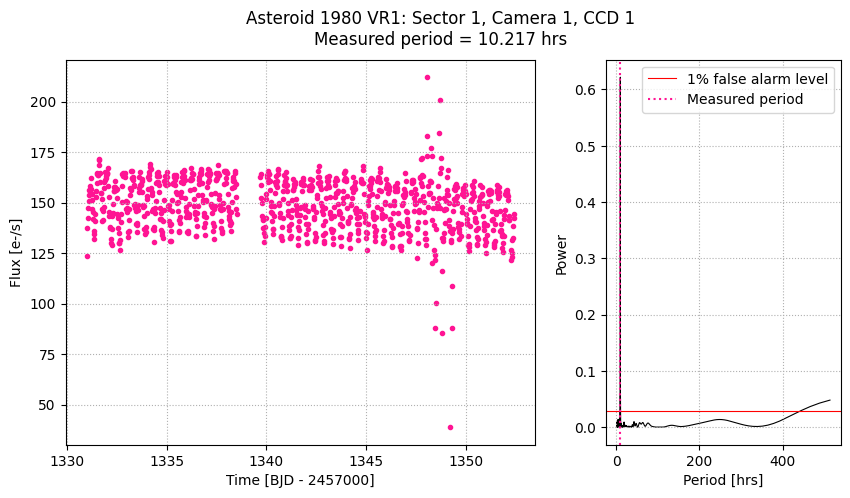

In [6]:
# Plot the LC and periodogram
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5), width_ratios=[2,1])

ax1.scatter(time, flux, color='deeppink', marker='.')
ax1.set_xlabel("Time [BJD - 2457000]")
ax1.set_ylabel("Flux [e-/s]")
ax1.grid(ls=":")

ax2.plot(period_grid*24, power, 'k', lw=0.8, zorder=0)
ax2.axhline(y=level, color='r', lw=0.8, label = "1% false alarm level")
ax2.axvline(x=best_period, ls=':', color='deeppink', zorder=2, label = "Measured period")
ax2.set_xlabel("Period [hrs]")
ax2.set_ylabel("Power")
ax2.legend(loc="upper right")
ax2.grid(ls=":")

fig.suptitle("Asteroid {0}: Sector {1}, Camera {2}, CCD {3}\nMeasured period = {4:.03f} hrs".format(target.target, target.sector,target.camera,target.ccd,best_period));

Yay, our results show good agreement with the expected rotation period!